In [1]:
import numpy as np
from skimage import io, transform
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models

from tqdm import tqdm

import pandas as pd
import os

%matplotlib inline

/home/sphere_7/anaconda3/envs/analytics/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
data = pd.read_csv('marks.csv', header=None)
data.head()

,0,1
0,Gesture_4/WIN_20171129_12_29_10_Pro (2).jpg,4
1,Gesture_4/WIN_20171214_18_12_33_Pro (2).jpg,4
2,Gesture_4/2017-11-26-145636_9.jpg,4
3,Gesture_4/WIN_20171203_17_26_42_Pro.jpg,4
4,Gesture_4/2017-11-26-150319_4.jpg,4


In [4]:
class GesturesDataset(Dataset):
    def __init__(self, pd_file, root_dir, transform=None):
        self.marks = pd_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.marks)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.marks.iloc[idx, 0])
        image = io.imread(img_name) * 1.0 / 255.0

#         if self.transform:
#             image = self.transform(image)

        sample = {'image': image, 'mark': self.marks.iloc[idx, 1] - 1}
            
        return sample

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
sss.get_n_splits(data, data[1])

1

In [6]:
for train_idxs, test_idxs in sss.split(data, data[1]):
    break

In [7]:
train_data, test_data = data.iloc[train_idxs, :], data.iloc[test_idxs, :]#train_test_split(data, test_size=0.1)

In [8]:
train_dataset = GesturesDataset(pd_file=train_data, root_dir='./')
train_dataloader = DataLoader(dataset=train_dataset, batch_size=10, num_workers=2, shuffle=True)

test_dataset = GesturesDataset(pd_file=test_data, root_dir='./')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=10, num_workers=2, shuffle=True)

In [9]:
alex = models.alexnet(pretrained=True).features.cuda()

In [10]:
for batch in train_dataloader:
    break

In [11]:
X = Variable(batch['image'].permute(0, 3, 1, 2).float())

In [12]:
alex(X.cuda()).size()

torch.Size([10, 256, 20, 20])

In [23]:
#model = nn.Sequential(nn.Linear(209664, 1000), nn.ReLU(), nn.Linear(1000, 5), nn.LogSoftmax()).cuda()
model = nn.Sequential(nn.Linear(102400, 5), nn.LogSoftmax()).cuda()
loss_fn = nn.NLLLoss()

In [8]:
# if we want to load model
c = torch.load('./alex-checkpoint-72.pth.tar')
model.load_state_dict(c['state_dict'])

In [25]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [27]:
def emulate(N, model, optimizer, loss_fn):
    n_epoch = N

    losses = np.zeros(n_epoch)
    test_losses = np.zeros(n_epoch)

    for i in range(n_epoch):
        for batch in train_dataloader:
            X = batch['image']
            y = batch['mark']
            
            X = X.permute(0, 3, 1, 2)
            X = normalize(X)
            X = Variable(X.float()).cuda()
            X = alex(X).data.view(X.size(0), -1)
            
            X = Variable(X, requires_grad=True).cuda()
            y = Variable(y.float(), requires_grad=False).cuda()
    
            y_pred = model(X)
            loss = loss_fn(y_pred, y.long())
            losses[i] = max(loss.data[0], losses[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(losses[i])
            
#         for batch in test_dataloader:
#             X = batch['image']
#             y = batch['mark']
            
#             X = X.permute(0, 3, 1, 2)
#             X = Variable(X.float()).cuda()
#             X = alex(X).data.view(X.size(0), -1)
            
#             X = Variable(X, requires_grad=True).cuda()
#             y = Variable(y.float(), requires_grad=False).cuda()
    
#             y_pred = model(X)
#             loss = loss_fn(y_pred, y.long())
#             test_losses[i] = max(loss.data[0], test_losses[i])            

#         if i != 0:
#             if losses[i] < 20 and losses[i] > 0:
#                 print(losses[i])
#                 break
    return losses, test_losses

In [28]:
losses, test_losses = emulate(50, model, optimizer, loss_fn)

2.62691354752
0.98714607954
0.983713924885
0.507203817368
0.393974483013
0.465896517038
0.34070199728
0.492848962545
0.11159569025
0.10994784534
0.0864415317774
0.0758791863918
0.114580787718
0.491577535868
0.0541619881988
0.0405991524458
0.0391044802964
0.0307763330638
0.0180729776621
0.0289400406182
0.0161418430507
0.0214527305216
0.0144738880917
0.0149487284943
0.0108005087823
0.0125125525519
0.0123002249748
0.0141970645636
0.0114177027717
0.00878156442195
0.00856838189065
0.00567733636126
0.00702386815101
0.00523225963116
0.00763060431927
0.00512969214469
0.00594659429044
0.00481987604871
0.00469883391634
0.00403691548854
0.00410195579752
0.00385072221979
0.00559620838612
0.00330114364624
0.00331882247701
0.00236276397482
0.00294780731201
0.00282273301855
0.0020385265816
0.00323140178807


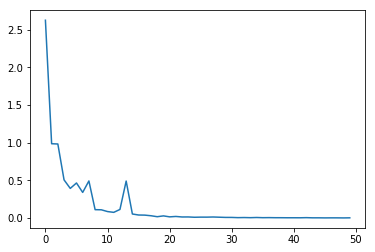

In [29]:
plt.plot(losses)

In [33]:
torch.save({
    'epoch': 50,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, './alex-checkpoint-87.pth.tar')

In [30]:
test_loss = 0
pred = []
correct = []

for batch in test_dataloader:
    X = batch['image']
    y = batch['mark']
    
    correct += list(y.numpy())
    
    X = X.permute(0, 3, 1, 2)
    X = normalize(X)
    X = Variable(X.float()).cuda()
    X = alex(X).data.view(X.size(0), -1)

    X = Variable(X, requires_grad=True).cuda()
    y = Variable(y.float(), requires_grad=False).cuda()
    
    y_pred = model(X)
    loss = loss_fn(y_pred, y.long())
    print(accuracy_score(y.cpu().data.numpy(), y_pred.cpu().data.numpy().argmax(axis=1)))
    test_loss = max(loss.data[0], test_loss)

    
    pred += list(y_pred.cpu().data.numpy().argmax(axis=1))

0.7
0.9
0.9
0.9
0.9
1.0
0.9
0.8
0.9
0.9
0.8
0.8
0.9
0.9
1.0
0.9
0.7
1.0
0.8
1.0
1.0
1.0
0.9
0.9
0.7
0.8
0.666666666667


In [31]:
accuracy_score(correct, pred)

0.87593984962406013

In [32]:
test_loss

1.2188005447387695

901

In [34]:
# save for cpu usage
model.cpu()
torch.save({
    'epoch': 50,
    'state_dict': model.state_dict(),
}, './alex-checkpoint-87-cpu.pth.tar')
model.cuda()

Sequential (
  (0): Linear (102400 -> 5)
  (1): LogSoftmax ()
)